#### Imports for main

In [2]:
from torchvision import torch, datasets, transforms
import torch.nn as nn
import torch.nn.functional as fnc
import cv2
from google.colab.patches import cv2_imshow
import os

#### Imports for model class

In [3]:
import numpy as np
from tqdm.notebook import tqdm

#### Imports for image manipulation functions

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

#### Mounting your Google Drive

**Note:** You will need to make a folder called "Colab Notebooks" in your Google Drive. Under this folder, make a folder called "MNIST_ocr". Store the image(s) to be analyzed in this folder under a folder called "test_images". Make another folder under MNIST_ocr called "bnw_images".

Alternatively, you can find pre-made folders at <a href="https://github.com/black-tul1p/digit-ocr">my GitHub repo</a>.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Global variables

In [5]:
image_size = 28*28
num_classes = 10
batch = 100
img_num = 3
debug = False

#### MNIST model class

In [6]:
## Class that defines the LR model
class MNIST_Model(nn.Module):
	def __init__(self):
		super().__init__()
		self.linear=nn.Linear(image_size, num_classes)

	def forward(self, image):
		image = image.reshape(-1, 784)
		output = self.linear(image)
		return output

	def training_step(self, batch):
		images, labels = batch
		output = self(images)
		loss = fnc.cross_entropy(output, labels)
		return loss
	
	def validation_step(self, batch):
		images, labels=batch
		output = self(images)
		loss = fnc.cross_entropy(output, labels)
		acc = get_accuracy(output, labels)
		return {'val_loss': loss, 'val_acc': acc}
	
	def validation_epoch_end(self, output):
		batch_losses=[x['val_loss'] for x in output]
		epoch_loss=torch.stack(batch_losses).mean()
		batch_accs=[x['val_acc'] for x in output]
		epoch_acc=torch.stack(batch_accs).mean()
		return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
	
	def epoch_end(self, epoch, result):
	  print("Epoch [{}], val_loss={:.4f}, val_acc={:.4f}".format(epoch, result['val_loss'], result['val_acc']))

#### Helper functions

In [37]:
# Calculate gradient values using Stochastic Gradient Descent
def get_gradient(epochs, model, lr, train_loader, test_loader):
	optimizer = torch.optim.SGD(model.parameters(), lr)
	for epoch in tqdm(range(epochs), desc='Training progress'):
		for batch in train_loader:
			loss = model.training_step(batch)
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()
		# Validation of predictions for epoch
		result = compare(model, test_loader)
		if debug == True:
			model.epoch_end(epoch, result)

# Get % accuracy of predictions
def get_accuracy(output, labels):
	_, predictions = torch.max(output, dim=1)
	return torch.tensor(torch.sum(predictions == labels).item()/len(predictions))

# Validates predictions
def compare(model, test_loader):
	out=[model.validation_step(batch) for batch in test_loader]
	return model.validation_epoch_end(out)

# Returns prediction for given image
def predict(image, model):
	xb=image.unsqueeze(0)
	yb=model(xb)
	_, preds=torch.max(yb, dim=1)
	return preds[0].item()
 
# Logo
def logo():
  print(r'''
	 ________  ___  ________  ___  _________        ________  ________  ________     
	|\   ___ \|\  \|\   ____\|\  \|\___   ___\     |\   __  \|\   ____\|\   __  \    
	\ \  \_|\ \ \  \ \  \___|\ \  \|___ \  \_|     \ \  \|\  \ \  \___|\ \  \|\  \   
	 \ \  \ \\ \ \  \ \  \  __\ \  \   \ \  \       \ \  \\\  \ \  \    \ \   _  _\  
	  \ \  \_\\ \ \  \ \  \|\  \ \  \   \ \  \       \ \  \\\  \ \  \____\ \  \\  \| 
	   \ \_______\ \__\ \_______\ \__\   \ \__\       \ \_______\ \_______\ \__\\ _\ 
	    \|_______|\|__|\|_______|\|__|    \|__|        \|_______|\|_______|\|__|\|__|
	                                                                    ~ Divay Gupta
  ''')

#### Image manipulation functions

In [8]:
def convert_bnw(in_path, out_path):
	rgb_image = Image.open(in_path)
	bnw_image = rgb_image.convert('L')
	bnw_image.save(out_path)

def resize_img(img_path):
	input_im = cv2.imread(img_path)
	input_im = cv2.resize(input_im, (28, 28))
	# cv2_imshow("image_converted", input_im)
	# cv2.waitKey(0)
	# cv2.destroyAllWindows()
	return input_im

def to_float_tensor(np_array):
	return torch.from_numpy(np_array).float()

#### Main function

In [39]:
def main():
	logo()

	choice = input("Train the model? (Y/N): ").lower()
	if choice == "y":
		num_epochs = int(input("Enter number of training Epochs: "))

	image_name = input("Enter image name (under /test_images/): ")
	if image_name == "":
		print("\nNo image specified. Defaulting to image_{}.jpg...\n".format(img_num))

	# Get MNIST training data
	mnist_train = datasets.MNIST(root="./gdrive/MyDrive/Colab Notebooks/MNIST_ocr/datasets", train=True, transform=transforms.ToTensor(), download=True)
	mnist_test = datasets.MNIST(root="./gdrive/MyDrive/Colab Notebooks/MNIST_ocr/datasets", train=False, transform=transforms.ToTensor(), download=True)

	# Load and shuffle dataset
	train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch, shuffle=True)
	test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch, shuffle=False)

	# Define model
	model = MNIST_Model()

	# saving the model
	if choice == "y":
		get_gradient(num_epochs, model, 0.4, train_loader, test_loader)
		torch.save(model.state_dict(), './gdrive/MyDrive/Colab Notebooks/MNIST_ocr/mnist-digit-ocr.pth')

	# Read image and convert to greyscale
	if image_name == "":
		in_path =  os.path.join(".", "gdrive", "MyDrive", "Colab Notebooks", "MNIST_ocr", "test_images", "image_"+str(img_num)+".png")
		out_path = os.path.join(".", "gdrive", "MyDrive", "Colab Notebooks", "MNIST_ocr", "bnw_images", "outfile"+str(img_num)+".png")
	else:
		in_path =  os.path.join(".", "gdrive", "MyDrive", "Colab Notebooks", "MNIST_ocr", "test_images", image_name)
		out_path = os.path.join(".", "gdrive", "MyDrive", "Colab Notebooks", "MNIST_ocr", "bnw_images", image_name)
	convert_bnw(in_path, out_path)
	plt.imshow(cv2.imread(in_path))

	# Resize and convert image to Tensor for analysis
	input_im = resize_img(out_path)
	input_im = to_float_tensor(input_im)

	# Load existing model if requested
	if choice != "y":
		model_new = MNIST_Model()
		model_new.load_state_dict(torch.load('./gdrive/MyDrive/Colab Notebooks/MNIST_ocr/mnist-digit-ocr.pth'))
		print('Predicted:', predict(input_im, model_new))
	else:
		print('Predicted:', predict(input_im, model))

#### Calling main


	 ________  ___  ________  ___  _________        ________  ________  ________     
	|\   ___ \|\  \|\   ____\|\  \|\___   ___\     |\   __  \|\   ____\|\   __  \    
	\ \  \_|\ \ \  \ \  \___|\ \  \|___ \  \_|     \ \  \|\  \ \  \___|\ \  \|\  \   
	 \ \  \ \\ \ \  \ \  \  __\ \  \   \ \  \       \ \  \\\  \ \  \    \ \   _  _\  
	  \ \  \_\\ \ \  \ \  \|\  \ \  \   \ \  \       \ \  \\\  \ \  \____\ \  \\  \| 
	   \ \_______\ \__\ \_______\ \__\   \ \__\       \ \_______\ \_______\ \__\\ _\ 
	    \|_______|\|__|\|_______|\|__|    \|__|        \|_______|\|_______|\|__|\|__|
	                                                                    ~ Divay Gupta
  
Train the model? (Y/N): n
Enter image name (under /test_images/): 

No image specified. Defaulting to image_3.jpg...

Predicted: 3


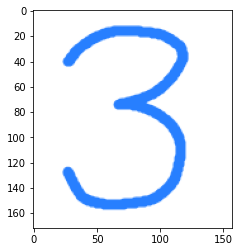

In [40]:
if __name__=="__main__":
	main()